In [172]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import math
import sys, os

from sklearn.linear_model import LogisticRegression as lr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False

reference: https://github.com/konosp/propensity-score-matching/blob/main/propensity_score_matching_v2.ipynb

In [160]:
# https://github.com/konosp/propensity-score-matching/blob/main/functions.py

def perform_match_exact(row, df , *args):
    # row is the the item that we want to match
    # df is the source Pandas dataframe that we want to match it with other items
    # print('Start matching')
    sub_set = df
    
    for arg in args:
        sub_set = sub_set.loc[sub_set[arg] == row[arg]]
        # print(sub_set)
        
    return sub_set.index


def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

    
def cohenD (tmp, metricName):
    treated_metric = tmp[tmp.treatment == 1][metricName]
    untreated_metric = tmp[tmp.treatment == 0][metricName]
    
    d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
    return d


In [250]:
# Density distribution of propensity score (logic) broken down by treatment status
def distribution_plots(predictions, predictions_logit, title='pscores') :
    fig, ax = plt.subplots(1,2, figsize=(13, 4.5))
#     fig.suptitle('Density distribution plots for propensity score and logit(propensity score)', 
#                  fontsize=13)
    sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
    ax[0].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[0].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[0].set_title('Propensity Score', fontsize=13)
    ax[0].legend(['immuno', 'chemo'], fontsize=13)
    sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
    ax[1].axvline(-0.4, ls='--')
    ax[1].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[1].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[1].set_title('Logit of Propensity Score', fontsize=13)
    ax[1].legend(['immuno', 'chemo'], fontsize=13)
    plt.savefig(title)
    plt.show()
    plt.close()

In [245]:
def status_matched_plot(matched, title='matched_discrepancy_regimenline') :
    #for var in ['age', 'sex', 'cancer_type']
    fig, ax = plt.subplots(1, 2, figsize=(13, 4.5))
    ax[0].hist(matched['age_io']-matched['age_chemo'], bins=20)
    ax[0].set_xlabel('Age difference between paired sample (io-chemo)', fontsize=13)
    ax[0].set_yscale('log')
    #ax[0].minorticks_on()
    #ax[0].yaxis.get_ticklocs(minor=True)     # []
    # Initialize minor ticks
    ax[0].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    cnt_sex = 0
    cnt_cancertype = 0
    for i, row in matched.iterrows() :
        if row['sex_io']!=row['sex_chemo'] :
            cnt_sex += 1
        if row['cancer_type_io']!=row['cancer_type_chemo'] :
            cnt_cancertype += 1
    ax[1].minorticks_on()
    ax[1].bar([-1, 1], [cnt_sex, cnt_cancertype])
    ax[1].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[1].set_xticks([-1, 1])
    ax[1].set_xticklabels(['Sex', 'Cancer type'], fontsize=13)
    #ax[1].set_yscale('log')
    plt.show()

In [248]:
def do_matching_v2(row, indexes, distances, data):
    #current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    current_index = int(row['seq'])
    prop_score_logit = row['propensity_score_logit']
    candidates = []
    for i, idx in enumerate(indexes[current_index,:]) :
        if (current_index!=idx) and (row['treatment']==1) and (data.iloc[idx]['treatment']==0):
            candidates.append(np.array([int(current_index), int(idx), distances[current_index,i]]))
    return np.array(candidates)

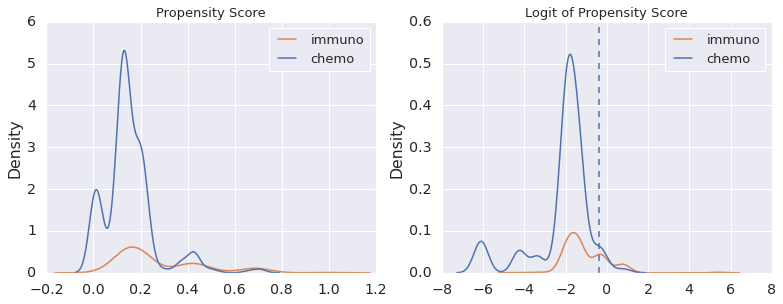

310 310


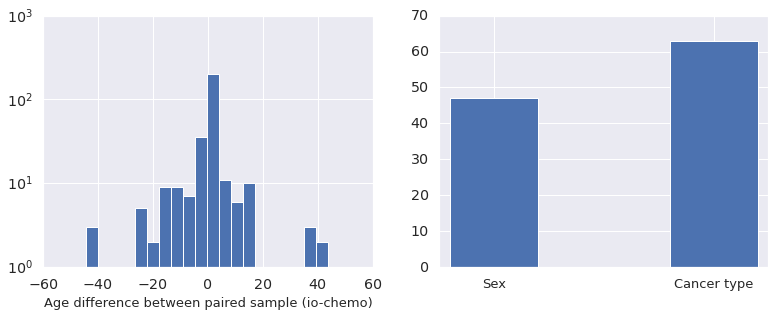

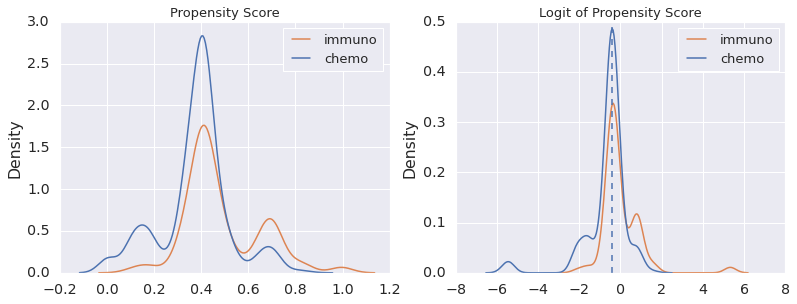

499 499


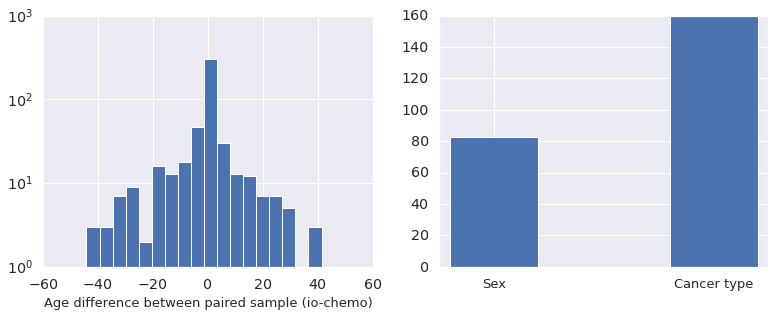

In [251]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

csvhead ='psmatched_set_regimen'
df = pd.read_csv("study_sample.csv")
for i, rgmline in enumerate([1, 2]) :
#for i, rgmline in enumerate([1]) :
    csvname = csvhead + str(rgmline) +".csv"
    data = df[df['regimen_line']==rgmline]
    data.loc[:, 'treatment'] = data['group'].apply(lambda x: 1 if x=='immuno' else 0)
#     display('1st line regimen')
#     display(pd.pivot_table(data[['treatment','sex','person_id']], \
#                values = 'person_id', index = 'treatment', columns = 'sex',\
#                aggfunc= np.count_nonzero))
    T = data['treatment']
    X = data.loc[:,('person_id','age', 'sex', 'kcd')]
    X_encoded = pd.get_dummies(X, columns = ['sex','kcd'], drop_first=False)
    
    pipe.fit(X_encoded.iloc[:, 1:], T)
    
    predictions = pipe.predict_proba(X_encoded.iloc[:, 1:])
    predictions_binary = pipe.predict(X_encoded.iloc[:, 1:])

#     print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
#     print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
#     print('F1 score is: {:.4f}'.format(metrics.f1_score(T, predictions_binary)))
    predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])
    
    distribution_plots(predictions, predictions_logit, 'pscores_regimen'+str(rgmline))
    
    data.loc[:,'propensity_score'] = predictions[:,1]
    data.loc[:,'propensity_score_logit'] = predictions_logit
    
    X_encoded.loc[:,'propensity_score'] = predictions[:,1]
    X_encoded.loc[:,'propensity_score_logit'] = predictions_logit
    X_encoded.loc[:,'treatment'] = data['treatment']
    
    caliper = np.std(X_encoded['propensity_score_logit']) * 0.0005

    #print('\nCaliper (radius) is: {:.10f}\n'.format(caliper))

    knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
    knn.fit(X_encoded[['propensity_score_logit']].to_numpy())
    
    distances , indexes = knn.kneighbors(
    X_encoded[['propensity_score_logit']].to_numpy(), n_neighbors=195*int(rgmline)**2)
    
#     print('For item 0, the 4 closest distances are (first item is self):')
#     for ds in distances[0,175:182]:
#         print('Element distance: {:.50f}'.format(ds))
#     print('...')

#     print('For item 0, the 4 closest indexes are (first item is self):')
#     for idx in indexes[0,0:4]:
#         print('Element index: {}'.format(idx))
#     print('...')
   
    data['seq'] = np.arange(0, len(data), 1)
    data['seq'] = data['seq'].astype(np.int64)
    data['matched_elements'] = data.apply(do_matching_v2, 
                                        axis = 1, args = (indexes, distances, data))
    data['n_matched'] = data['matched_elements'].apply(lambda x: len(x))
    treated_with_match = data['n_matched']!=0
    
    treated_matched_data = data[treated_with_match][data.columns]
    swab = treated_matched_data['matched_elements'].to_numpy()
    swabs = []
    for j in range(swab.shape[0]) : 
        for k in range(swab[j].shape[0]):
            swabs.append(swab[j][k, :])
    swabs = np.asarray(swabs)
    
    swab = swabs[swabs[:, 2].argsort()]
    pairs_dict = {}
    for j, k, d in swab :
        if not j in pairs_dict and not k in pairs_dict.values() :
            pairs_dict[int(j)] = int(k)
        if len(pairs_dict) == treated_matched_data.shape[0] :
            break
    tmp = list(pairs_dict.items())
    print(treated_matched_data.shape[0], len(set(tmp)))
    pairs_df = pd.DataFrame(list(pairs_dict.items()),
                            columns=['seq', 'untreatment_seq'])
#     print(pairs_df)
    treated_matched_data = pd.merge(treated_matched_data, pairs_df, how='left', on='seq') 
 
    matched_set = pd.merge(treated_matched_data, data, how='left',
                          left_on='untreatment_seq', right_on='seq', 
                          suffixes=('_io', '_chemo'))
    matched_set[['person_id_io', 'sex_io', 'age_io', 'cancer_type_io', 'kcd_io',
                'group_io', 'regimen_line_io', 'treatment_io', 'propensity_score_io',
                'propensity_score_logit_io', 'person_id_chemo', 'sex_chemo',
                'age_chemo', 'cancer_type_chemo', 'kcd_chemo', 'group_chemo',
                'regimen_line_chemo', 'treatment_chemo', 'propensity_score_chemo',
                'propensity_score_logit_chemo']].to_csv(csvname, index=False)

    status_matched_plot(matched_set, 'matched_discrepancy_regimenline'+str(rgmline))
        

#### Curating sample

In [275]:
sample_total = pd.read_csv("study_sample.csv")
rgml1 = pd.read_csv("psmatched_set_regimen1.csv")
rgml2 = pd.read_csv("psmatched_set_regimen2.csv")
sample_rgml_more2 = sample_total[sample_total['regimen_line']>2]
sample_rgml_more2['person_id_chemo'] = np.nan
sample_rgml_more2['person_id_immuno'] = np.nan
#display(rgml1[['person_id_io', 'person_id_chemo']])
#display(rgml2[['person_id_io', 'person_id_chemo']])
# combine regimen line 1, 2 with sample_rgml_more2
for i, rgm_file in enumerate(["psmatched_set_regimen1.csv", "psmatched_set_regimen2.csv"]) :
    rgml = pd.read_csv(rgm_file)
    tmp = pd.merge(sample_total, rgml[['person_id_io', 'person_id_chemo']], how='right', 
                    left_on='person_id', right_on='person_id_io')
    io_tmp = tmp.drop(columns = ['person_id_io'])
    io_tmp['person_id_immuno'] = np.nan
    chemo_tmp = pd.merge(sample_total, rgml[['person_id_io', 'person_id_chemo']], 
                          how='right', left_on='person_id', right_on='person_id_chemo')\
                          .rename(columns = {'person_id_io':'person_id_immuno'})
    chemo_tmp['person_id_chemo'] = np.nan
    if i == 0 :
        sample_rgmline12 = pd.concat([io_tmp, chemo_tmp], ignore_index=True)
    else :
        tmp = pd.concat([io_tmp, chemo_tmp], ignore_index=True)
        sample_rgmline12 = pd.concat([sample_rgmline12, tmp], ignore_index=True)
sample_total = pd.concat([sample_rgmline12, sample_rgml_more2], ignore_index=True)
display(sample_total)
sample_total.to_csv("sample_matched_by_regimen.csv", index=False)
# tmp = pd.merge(sample_total, rgml2[['person_id_io', 'person_id_chemo']], how='right', 
#                 left_on='person_id', right_on='person_id_io')
# io_tmp2 = tmp.drop(columns = ['person_id_io'])
# display(tmp2)
# display(sample_rgml_more2)

,person_id,sex,age,cancer_type,kcd,group,regimen_line,person_id_chemo,person_id_immuno
0,266,Male,68.563997,lung,C34,immuno,1,1761.0,NaN
1,1229,Male,68.492813,lung,C34,immuno,1,1980.0,NaN
2,1284,Male,57.073238,lung,C34,immuno,1,3560.0,NaN
3,1286,Male,56.925394,lung,C34,immuno,1,2659.0,NaN
4,1237,Male,72.134155,lung,C34,immuno,1,4383.0,NaN
...,...,...,...,...,...,...,...,...,...
3132,5050,Male,25.880903,lung,C34,chemo,3,NaN,NaN
3133,4995,Male,63.140315,lung,C34,chemo,3,NaN,NaN
3134,5052,Female,44.298426,brain,C71,chemo,3,NaN,NaN
3135,5036,Female,35.789185,breast,C50,chemo,4,NaN,NaN
